Quellen für Code:
- GraphSage: https://stellargraph.readthedocs.io/en/stable/demos/node-classification/graphsage-node-classification.html
- Node2Vec: https://stellargraph.readthedocs.io/en/stable/demos/node-classification/node2vec-node-classification.html

TO-DO:
- Dokumentation schreiben

2BkVxLwo0W0Brd79RYEMndZZuZL_2CnETspW7En9vkAPKu7Tz

# Install & Code

In [12]:
#@title Install für die Verfahren
try:
    import stellargraph
except:
    !pip install stellargraph
    import stellargraph
from google.colab import output
output.clear()

import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE
from stellargraph.mapper import FullBatchNodeGenerator # GCN
from stellargraph.layer import GCN # GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import numpy as np

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

%matplotlib inline




In [13]:
#@title Code für die Verfahren
######################
###   Funktionen   ###
######################

def get_cardinality(edge_list):
    """
    übernimmt eine Liste mit zweier Tupeln -> edges [(1033, 35), (103482, 35), (103515, 35), ...]
    Return ein Dictonary mit den Einträgen und der Häufigkeit 
    """

    distribution_dict = {}
    for node_A, node_B in edge_list:
        if node_A not in distribution_dict:
            distribution_dict[node_A] = 1
        else:
            distribution_dict[node_A] += 1
        if node_B not in distribution_dict:
            distribution_dict[node_B] = 1
        else:
            distribution_dict[node_B] += 1
    card_dict={}
    for node, count in distribution_dict.items():
        if count not in card_dict:
            card_dict[count] = []
            card_dict[count].append(node)
        else:
            card_dict[count].append(node)
    return card_dict # {card: [node1, node2], ...}


def get_sub_graph(graph, prozent):
    G = graph.G
    anzahl_nodes = len(G.nodes())
    loesch_prozent = prozent
    anz_del_nodes = round( anzahl_nodes * loesch_prozent ) 

    graph_card_dict = get_cardinality( G.edges())
    card_list = list(graph_card_dict.keys())
    card_list.sort()
    delete_nodes = []
    for card in reversed(card_list):
        for element in graph_card_dict[card]:
            if anz_del_nodes > len(delete_nodes):
                delete_nodes.append(element)
    rest_nodes = [n for n in G.nodes() if n not in delete_nodes]

    return G.subgraph(nodes=rest_nodes)


def get_graph(name):
    if name == "Cora":
        return sg.datasets.Cora()
    if name == "CiteSeer":
        return sg.datasets.CiteSeer()
    if name == "PubMed Diabetes":
        return sg.datasets.PubMedDiabetes()
    if name == "MovieLens":
        return sg.datasets.MovieLens()   
    if name == "BlogCatalog3":
        return sg.datasets.BlogCatalog3()
    if name == "AIFB":
        return sg.datasets.AIFB()
    if name == "MUTAG":
        return sg.datasets.MUTAG()
    if name == "PROTEINS":
        return sg.datasets.PROTEINS()
    if name == "WN18":
        return sg.datasets.WN18()
    if name == "WN18RR":
        return sg.datasets.WN18RR()
    if name == "FB15k":
        return sg.datasets.FB15k()
    if name == "FB15k_237":
        return sg.datasets.FB15k_237()
    if name == "IAEnronEmployees":
        return sg.datasets.IAEnronEmployees()
    print("Es wurde kein passender Graph angegeben \ndefault Cora")
    return sg.datasets.Cora()


#####################
###    Node2Vec   ###
#####################

def node2vec(G, node_subjects,
             user_length=100, 
             user_n=10, 
             user_p=0.5, 
             user_q=2.0,
             my_graph="Cora"):
  
  ## Loading Graph ##

  #Auswahl alternativer Graphen unter folgender URL
  #https://stellargraph.readthedocs.io/en/v1.2.1/_modules/stellargraph/datasets/datasets.html

  # Folgende Graphen funktionieren: Cora(), PubMedDiabetes()
  # Folgende Graphen funktionieren nicht: CiteSeer(), BlogCatalog3(), MovieLens(), AIFB(), MUTAG(), PROTEINS(), WN18(), WN18RR(), FB15k(), FB15k_237(), IAEnronEmployees(), METR_LA()
  # dataset = my_dataset
  # display(HTML(dataset.description))
  # G, node_subjects = dataset.load() 
  #print(G.info())


  ## Modellerstellung mit Random walks ##

  rw = BiasedRandomWalk(G)

  walks = rw.run(
      nodes=list(G.nodes()),  # root nodes
      length=user_length,  # maximum length of a random walk
      n=user_n,  # number of random walks per root node
      p=user_p,  # Defines (unormalised) probability, 1/p, of returning to source node
      q=user_q,  # Defines (unormalised) probability, 1/q, for moving away from source node
  )
  print("Number of random walks: {}".format(len(walks)))



  ## Learning mit Word2Vec ##

  from gensim.models import Word2Vec

  str_walks = [[str(n) for n in walk] for walk in walks]
  model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

  # The embedding vectors can be retrieved from model.wv using the node ID as key.
  model.wv[str(G.nodes()[0])].shape
  #print(str(G.nodes()[0]))


  ## Erstellen der Node Embeddings mit t-SNE ##

  # Retrieve node embeddings and corresponding subjects
  node_ids = model.wv.index2word  # list of node IDs
  node_embeddings = (
      model.wv.vectors
  )  # numpy.ndarray of size number of nodes times embeddings dimensionality

  if my_graph == "CiteSeer":
    node_targets = node_subjects[[node_id for node_id in node_ids]]
  else:
    node_targets = node_subjects[[int(node_id) for node_id in node_ids]]


  # Apply t-SNE transformation on node embeddings
  tsne = TSNE(n_components=2)
  node_embeddings_2d = tsne.fit_transform(node_embeddings)


  # draw the points
  alpha = 0.7
  label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
  node_colours = [label_map[target] for target in node_targets]

  plt.figure(figsize=(10, 8))
  plt.scatter(
      node_embeddings_2d[:, 0],
      node_embeddings_2d[:, 1],
      c=node_colours,
      cmap="jet",
      alpha=alpha,
  )

  return node_embeddings_2d


#####################
###   GraphSAGE   ###
#####################

def graph_sage(G, node_subjects, 
               layer_value=32, number_nodes = 10, epoch_value=3):
    # dataset = my_dataset
    # display(HTML(dataset.description))
    # G, node_subjects = dataset.load()

    #Splitting the data
    train_subjects, test_subjects = model_selection.train_test_split(
        node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
    )

    #from collections import Counter
    #Counter(train_subjects)
    #Counter(test_subjects) --> es liegen viel mehr Testdaten vor


    target_encoding = preprocessing.LabelBinarizer()

    train_targets = target_encoding.fit_transform(train_subjects)
    test_targets = target_encoding.transform(test_subjects)

    ## Modellerstellung

    # Creating the GraphSAGE model in Keras
    batch_size = int(number_nodes * (number_nodes/2))
    num_samples = [number_nodes, int(number_nodes/2)]

    generator = GraphSAGENodeGenerator(G, batch_size, num_samples)#feed data from the graph to the Keras model we need a data generator --> wir lernen heri basierend auf Knotenattributen, daher kann man diese im Anschluss vorhersagen

    train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

    graphsage_model = GraphSAGE(
        layer_sizes=[layer_value, layer_value], generator=generator, bias=True, dropout=0.5,
    )

    x_inp, x_out = graphsage_model.in_out_tensors()
    prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

    ## Trainieren des Modells mit Trainingsdaten

    #Training the model
    model = Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=optimizers.Adam(lr=0.005),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )
    test_gen = generator.flow(test_subjects.index, test_targets)

    history = model.fit(
        train_gen, epochs=epoch_value, validation_data=test_gen, verbose=2, shuffle=False #Achtung epochs müssen noch weiter hoch gesetzt werden
    )

    sg.utils.plot_history(history)

    ## Evaluieren des Modells mit den Testdaten, Prediction

    #Evaluation of the model
    test_metrics = model.evaluate(test_gen)
    print("\nTest Set Metrics:")
    for name, val in zip(model.metrics_names, test_metrics):
        print("\t{}: {:0.4f}".format(name, val))

    #Predictions
    all_nodes = node_subjects.index
    all_mapper = generator.flow(all_nodes)
    all_predictions = model.predict(all_mapper)

    node_predictions = target_encoding.inverse_transform(all_predictions)
    df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
    #df.head(30)

    #Gnx = G.to_networkx(feature_attr=None)
    #for nid, pred, true in zip(df.index, df["Predicted"], df["True"]):
    #    Gnx.nodes[nid]["subject"] = true
    #    Gnx.nodes[nid]["PREDICTED_subject"] = pred.split("=")[-1]

    #for nid in train_subjects.index:
    #    Gnx.nodes[nid]["isTrain"] = True

    #for nid in test_subjects.index:
    #    Gnx.nodes[nid]["isTrain"] = False

    #for nid in Gnx.nodes():
    #    Gnx.nodes[nid]["isCorrect"] = (
    #        Gnx.nodes[nid]["subject"] == Gnx.nodes[nid]["PREDICTED_subject"]
    #    )

    #pred_fname = "pred_n={}.graphml".format(num_samples)
    #nx.write_graphml(Gnx, os.path.join(dataset.data_directory, pred_fname))

    ## Erstellen der Node Embeddings

    #node Embeddings

    embedding_model = Model(inputs=x_inp, outputs=x_out)
    emb = embedding_model.predict(all_mapper)
    emb.shape

    X = emb
    y = np.argmax(target_encoding.transform(node_subjects), axis=1)

    if X.shape[1] > 2:
        transform = TSNE  # PCA

        trans = transform(n_components=2)
        emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_subjects.index)
        emb_transformed["label"] = y
    else:
        emb_transformed = pd.DataFrame(X, index=node_subjects.index)
        emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
        emb_transformed["label"] = y

    alpha = 0.7

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(
        emb_transformed[0],
        emb_transformed[1],
        c=emb_transformed["label"].astype("category"),
        cmap="jet",
        alpha=alpha,
    )
    ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
    plt.title(
        "{} visualization of GraphSAGE embeddings for cora dataset".format(transform.__name__)
    )
    plt.show()


#####################
###     GCN       ###
#####################

def gcn(G, node_subjects,
        train_subjects_train_size = 140,
        val_subjects_train_size = 500,

        my_layer_sizes = [16, 16],
        my_activations=["relu", "relu"],
        my_dropout=0.5,
        my_predict_activation="softmax",

        my_epochs=200):
    """
    GCN ist cool
    """

    # dataset = my_dataset
    # display(HTML(dataset.description))
    # G, node_subjects = dataset.load()

    node_subjects.value_counts().to_frame()
    train_subjects, test_subjects = model_selection.train_test_split(
        node_subjects, train_size=train_subjects_train_size, test_size=None, stratify=node_subjects
    )
    val_subjects, test_subjects = model_selection.train_test_split(
        test_subjects, train_size=val_subjects_train_size, test_size=None, stratify=test_subjects
    )
    train_subjects.value_counts().to_frame()
    target_encoding = preprocessing.LabelBinarizer()
    train_targets = target_encoding.fit_transform(train_subjects)
    val_targets = target_encoding.transform(val_subjects)
    test_targets = target_encoding.transform(test_subjects)
    generator = FullBatchNodeGenerator(G, method="gcn")
    train_gen = generator.flow(train_subjects.index, train_targets)
    gcn = GCN(
        layer_sizes=my_layer_sizes, 
        activations=my_activations, 
        generator=generator, 
        dropout=my_dropout
    )
    print("OK")
    x_inp, x_out = gcn.in_out_tensors()

    x_out

    predictions = layers.Dense(units=train_targets.shape[1], 
                               activation=my_predict_activation)(x_out)

    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(
        optimizer=optimizers.Adam(lr=0.01),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )

    val_gen = generator.flow(val_subjects.index, val_targets)

    from tensorflow.keras.callbacks import EarlyStopping

    es_callback = EarlyStopping(monitor="val_acc", patience=50, 
                                restore_best_weights=True)



    history = model.fit(
        train_gen,
        epochs=my_epochs,
        validation_data=val_gen,
        verbose=2,
        shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
        callbacks=[es_callback],
    )



    sg.utils.plot_history(history)



    test_gen = generator.flow(test_subjects.index, test_targets)

    test_metrics = model.evaluate(test_gen)
    print("\nTest Set Metrics:")
    for name, val in zip(model.metrics_names, test_metrics):
        print("\t{}: {:0.4f}".format(name, val))



    all_nodes = node_subjects.index
    all_gen = generator.flow(all_nodes)
    all_predictions = model.predict(all_gen)

    node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())



    df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
    df.head(20)

    embedding_model = Model(inputs=x_inp, outputs=x_out)

    emb = embedding_model.predict(all_gen)
    emb.shape



    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE

    transform = TSNE  # or PCA



    X = emb.squeeze(0)
    X.shape

    trans = transform(n_components=2)
    X_reduced = trans.fit_transform(X)
    X_reduced.shape



    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        c=node_subjects.astype("category").cat.codes,
        cmap="jet",
        alpha=0.7,
    )
    ax.set(
        aspect="equal",
        xlabel="$X_1$",
        ylabel="$X_2$",
        title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
    )


class MyGraph:
    def __init__(self, dataset):
        G, node_subjects = dataset.load()
        self.G = G
        self.node_subjects = node_subjects
    def set_graph(self, sub_G):
        self.G = sub_G
#####################
### ENDE Programm ###
#####################

# GUI

Konfig 1 GraphSAGE 

    node features at each layer:


IntText(value=32)

Output()

    nodes observed at each level:


IntText(value=10)

Output()

    Epochs:


IntText(value=10)

Output()



Konfig 2 GraphSAGE 

    node features at each layer:


IntText(value=32)

Output()

    nodes observed at each level:


IntText(value=10)

Output()

    Epochs:


IntText(value=10)

Output()


Manipulation
    Kardinalität anpassen:


IntSlider(value=10)

Output()

Button(description='Anpassen 1', style=ButtonStyle())

Output()

    Kardinalität anpassen:


IntSlider(value=10)

Output()

Button(description='Anpassen 2', style=ButtonStyle())

Output()

Button(description='RUN', style=ButtonStyle())

Output()

Davor StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none 
-----------


Danach StellarGraph: Undirected multigraph
 Nodes: 2437, Edges: 2369

 Node types:
  paper: [2437]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [2369]
        Weights: all 1 (default)
        Features: none 
-----------

Davor StellarGraph: Undirected multigraph
 Nodes: 2437, Edges: 2369

 Node types:
  paper: [2437]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [2369]
        Weights: all 1 (default)
        Features: none 
-----------


Danach StellarGraph: Undirected multigraph
 Nodes: 2193, Edges: 1393

 Node types:
  paper: [2193]
    Features: float32 vector

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


6/6 - 4s - loss: 1.8823 - acc: 0.2704 - val_loss: 1.6995 - val_acc: 0.3441 - 4s/epoch - 673ms/step
Epoch 2/10
6/6 - 3s - loss: 1.6440 - acc: 0.4222 - val_loss: 1.5291 - val_acc: 0.4930 - 3s/epoch - 505ms/step
Epoch 3/10
6/6 - 3s - loss: 1.4848 - acc: 0.6370 - val_loss: 1.3591 - val_acc: 0.7121 - 3s/epoch - 418ms/step
Epoch 4/10
6/6 - 3s - loss: 1.3135 - acc: 0.8111 - val_loss: 1.2266 - val_acc: 0.7834 - 3s/epoch - 445ms/step
Epoch 5/10
6/6 - 2s - loss: 1.1741 - acc: 0.8926 - val_loss: 1.1210 - val_acc: 0.7945 - 2s/epoch - 397ms/step
Epoch 6/10
6/6 - 2s - loss: 1.0691 - acc: 0.9037 - val_loss: 1.0297 - val_acc: 0.8179 - 2s/epoch - 409ms/step
Epoch 7/10
6/6 - 3s - loss: 0.9561 - acc: 0.9185 - val_loss: 0.9567 - val_acc: 0.8253 - 3s/epoch - 503ms/step
Epoch 8/10
6/6 - 2s - loss: 0.8389 - acc: 0.9556 - val_loss: 0.9005 - val_acc: 0.8183 - 2s/epoch - 406ms/step
Epoch 9/10
6/6 - 2s - loss: 0.7503 - acc: 0.9778 - val_loss: 0.8456 - val_acc: 0.8240 - 2s/epoch - 413ms/step
Epoch 10/10
6/6 - 3s 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


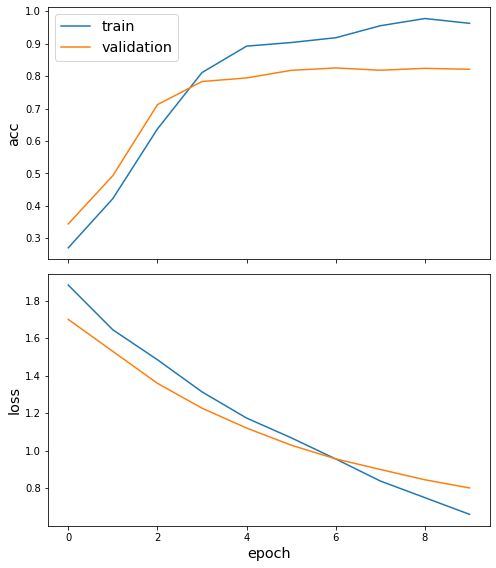

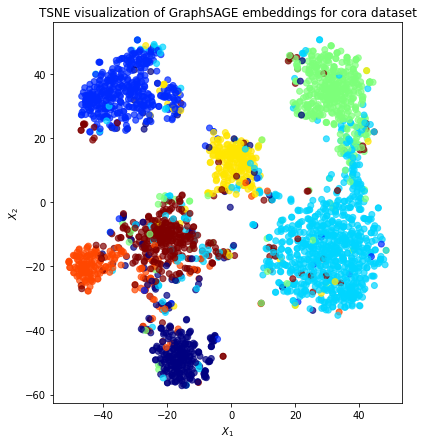


-----------------------------
StellarGraph: Undirected multigraph
 Nodes: 2437, Edges: 2369

 Node types:
  paper: [2437]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [2369]
        Weights: all 1 (default)
        Features: none <stellargraph.core.graph.StellarGraph object at 0x7fe607ca6310>
layer value 32
Number nodes 10
Epochs 10
-----------------------------

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


6/6 - 5s - loss: 1.8776 - acc: 0.2519 - val_loss: 1.7051 - val_acc: 0.3843 - 5s/epoch - 760ms/step
Epoch 2/10
6/6 - 3s - loss: 1.6593 - acc: 0.4037 - val_loss: 1.5909 - val_acc: 0.4401 - 3s/epoch - 504ms/step
Epoch 3/10
6/6 - 2s - loss: 1.5135 - acc: 0.5556 - val_loss: 1.4625 - val_acc: 0.5332 - 2s/epoch - 414ms/step
Epoch 4/10
6/6 - 2s - loss: 1.3909 - acc: 0.6444 - val_loss: 1.3527 - val_acc: 0.6132 - 2s/epoch - 395ms/step
Epoch 5/10
6/6 - 2s - loss: 1.2459 - acc: 0.7926 - val_loss: 1.2528 - val_acc: 0.6760 - 2s/epoch - 384ms/step
Epoch 6/10
6/6 - 3s - loss: 1.1327 - acc: 0.8222 - val_loss: 1.1647 - val_acc: 0.7342 - 3s/epoch - 505ms/step
Epoch 7/10
6/6 - 2s - loss: 1.0073 - acc: 0.8889 - val_loss: 1.0805 - val_acc: 0.7855 - 2s/epoch - 409ms/step
Epoch 8/10
6/6 - 3s - loss: 0.9179 - acc: 0.9222 - val_loss: 1.0137 - val_acc: 0.7961 - 3s/epoch - 502ms/step
Epoch 9/10
6/6 - 3s - loss: 0.8238 - acc: 0.9333 - val_loss: 0.9443 - val_acc: 0.8060 - 3s/epoch - 505ms/step
Epoch 10/10
6/6 - 3s 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


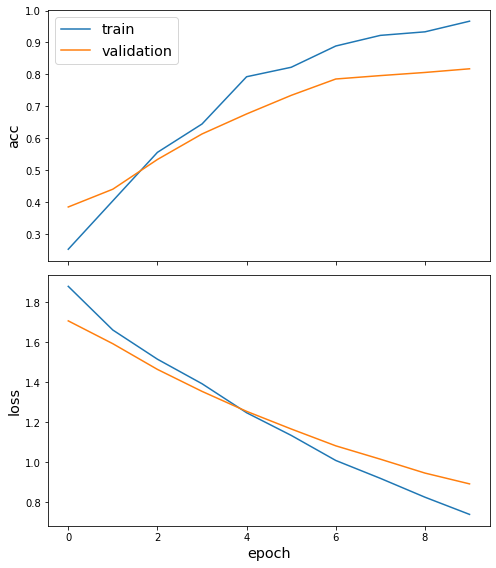

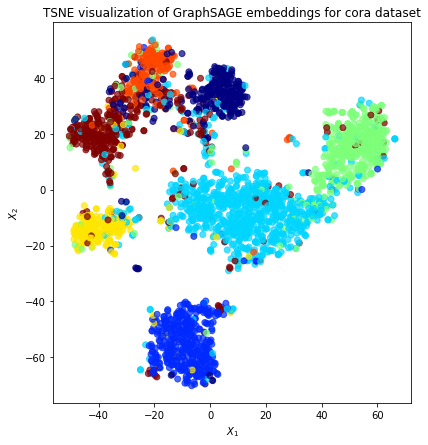

In [32]:
#Siehe hier: https://ipywidgets.readthedocs.io/en/latest/embedding.html


#@title Embeding vergleichen { display-mode: "form" , run:"auto"}
import ipywidgets as widgets
from IPython.display import display
import functools

# https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#Numeric-widgets

button_run = widgets.Button(description="RUN")
button_an1 = widgets.Button(description="Anpassen 1")
button_an2 = widgets.Button(description="Anpassen 2")
output = widgets.Output()


input_cardinality = widgets.IntSlider(
    value=10,
    min=0,
    max=100,
    step=1,
    # description='Kardinalität anpassen:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    
)

input_cardinality_2 = widgets.IntSlider(
    value=10,
    min=0,
    max=100,
    step=1,
    # description='Kardinalität anpassen:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    
)

##########################
### Node2Vec widgets ###
##########################
eingabe_node2vec_walklength = widgets.IntSlider(
    value=100,
    min=1,
    max=150,
    step=1,
    # description='Max. length of a random walk:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    
)

eingabe_node2vec_numberOfWalks = widgets.IntSlider(
    value=10,
    min=1,
    max=20,
    step=1,
    # description='Number of walks:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

eingabe_node2vec_p = widgets.FloatSlider(
    value=0.5,
    min=0.05,
    max=1.0,
    step=0.05,
    # description='P:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

eingabe_node2vec_q = widgets.FloatSlider(
    value=2.0,
    min=0.5,
    max=4.0,
    step=0.5,
    # description='Q:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

## COPY

eingabe_node2vec_walklength_2 = widgets.IntSlider(
    value=100,
    min=1,
    max=150,
    step=1,
    # description='Max. length of a random walk:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    
)

eingabe_node2vec_numberOfWalks_2 = widgets.IntSlider(
    value=10,
    min=1,
    max=20,
    step=1,
    # description='Number of walks:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

eingabe_node2vec_p_2 = widgets.FloatSlider(
    value=0.5,
    min=0.05,
    max=1.0,
    step=0.05,
    # description='P:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

eingabe_node2vec_q_2 = widgets.FloatSlider(
    value=2.0,
    min=0.5,
    max=4.0,
    step=0.5,
    # description='Q:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
###########################
### GraphSAGE widgets ###
###########################

#layer_value=32 #Werte Range 10 bis 100 ANz. Dimensionen der Knotenmerkmale pro Schicht
#number_nodes = 10 #Anzahl der Knoten, die auf der ersten Ebene der Modells untersucht werden (2-Ebenen Modell, zweite Ebene wird automatisch berechnet, für mehr reicht Rechenleistung nicht aus)
#epoch_value=10 

input_graphSAGE_layer_value = widgets.IntText(
    value='32',
    placeholder='32',
    # description='node features at each layer:',
    disabled=False
)

input_graphSAGE_number_nodes = widgets.IntText(
    value='10',
    placeholder='10',
    # description='nodes observed at each level:',
    disabled=False
)

input_graphSAGE_epochs = widgets.IntText(
    value='10',
    placeholder='10',
    # description='epochs:',
    disabled=False
)
## COPY
input_graphSAGE_layer_value_2 = widgets.IntText(
    value='32',
    placeholder='32',
    # description='node features at each layer:',
    disabled=False
)
input_graphSAGE_number_nodes_2 = widgets.IntText(
    value='10',
    placeholder='10',
    # description='nodes observed at each level:',
    disabled=False
)

input_graphSAGE_epochs_2 = widgets.IntText(
    value='10',
    placeholder='10',
    # description='epochs:',
    disabled=False
)
#####################
### GCN widgets ###
#####################
# Parameter und Beispielwerte für den Cora Graph
# input_gcn_train_subjects_train_size = 140
# input_gcn_val_subjects_train_size = 500
# input_gcn_my_layer_sizes = [16, 16]
# input_gcn_my_activations=["relu", "relu"]
# input_gcn_my_dropout=0.5
# input_gcn_my_predict_activation="softmax"
# input_gcn_my_epochs=200

input_gcn_train_subjects_train_size = widgets.IntText(
    value=140,
    # description='Train size:',
    disabled=False
)

input_gcn_val_subjects_train_size = widgets.IntText(
    value=500,
    # description='Val Train size:',
    disabled=False
)

input_gcn_my_layer_sizes = widgets.Text(
    value='16, 16',
    placeholder='16, 16',
    # description='Layer size:',
    disabled=False
)

input_gcn_my_activations= widgets.Dropdown(options=['relu', 'softmax', 'elu'],
    value='relu',
    # description='Aktivierungsfunktion:',
    disabled=False,
)

input_gcn_my_dropout= widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1.0,
    step=0.05,
    # description='dropout:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

input_gcn_my_predict_activation= widgets.Dropdown(options=['relu', 'softmax', 'elu'],
    value='softmax',
    # description='Predict Aktivierungsfunktion:',
    disabled=False,
)

input_gcn_my_epochs = widgets.IntText(
    value=200,
    # description='Epochs:',
    disabled=False
)

## COPY


input_gcn_train_subjects_train_size_2 = widgets.IntText(
    value=140,
    # description='Train size:',
    disabled=False
)

input_gcn_val_subjects_train_size_2 = widgets.IntText(
    value=500,
    # description='Val Train size:',
    disabled=False
)

input_gcn_my_layer_sizes_2 = widgets.Text(
    value='16, 16',
    placeholder='16, 16',
    # description='Layer size:',
    disabled=False
)

input_gcn_my_activations_2 = widgets.Dropdown(options=['relu', 'softmax', 'elu'],
    value='relu',
    # description='Aktivierungsfunktion:',
    disabled=False,
)

input_gcn_my_dropout_2 = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1.0,
    step=0.05,
    # description='dropout:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

input_gcn_my_predict_activation_2 = widgets.Dropdown(options=['relu', 'softmax', 'elu'],
    value='softmax',
    # description='Predict Aktivierungsfunktion:',
    disabled=False,
)

input_gcn_my_epochs_2 = widgets.IntText(
    value=200,
    # description='Epochs:',
    disabled=False
)

######################
### ENDE widgets ###
######################

###############
### Display ###
###############

# Dropdown 1 -> Graph wählen
graph_name = "Cora" #@param ["Cora", "PubMed Diabetes", "CiteSeer"] {allow-input: true}
verfahren_1 = "GraphSAGE" #@param ["node2vec", "GraphSAGE", "GCN"] {allow-input: true}
verfahren_2 = "GraphSAGE" #@param ["node2vec", "GraphSAGE", "GCN"] {allow-input: true}

graph = MyGraph(get_graph(graph_name))
graph_1 = MyGraph(get_graph(graph_name))
graph_2 = MyGraph(get_graph(graph_name))

# print(graph_1.G.info())
# dataset_1 = get_graph(graph)
# dataset_2 = get_graph(graph)
# graph_1, node_subjects_1 = dataset_1.load()
# graph_2, node_subjects_2 = dataset_2.load()


def on_button_card_an1( graph_1, _):
    print("Davor", graph_1.G.info(), "\n-----------\n")
    card1 = get_cardinality(graph_1.G.edges())
    graph_1.set_graph(get_sub_graph(graph_1, input_cardinality.value / 100 ) )
    print("\nDanach", graph_1.G.info(), "\n-----------\n")


def on_button_card_an2( graph_2, _):
    print("\nDavor-----------\n", graph_2.G.info(),"\n-----------\n")
    card2 = get_cardinality(graph_2.G.edges())
    graph_2.set_graph(get_sub_graph(graph_2, input_cardinality_2.value / 100) )
    print("\nDanach-----------\n", graph_2.G.info(), "\n-----------\n")


def on_button_run(b):

    if verfahren_1 == "GCN":
        tmp =  [int(i) for i in input_gcn_my_layer_sizes.value.split(",")]
        print("\n-----------------------------")
        print(graph_1.G.info(), graph_1.G)
        # print(graph_1.node_subjects)
        print("train_size", input_gcn_train_subjects_train_size.value)
        print("val_train_size", input_gcn_val_subjects_train_size.value)
        print("my_layer_size", tmp)
        print("my_activations", [input_gcn_my_activations.value] * len(tmp) )
        print("dropout", input_gcn_my_dropout.value)
        print("predict_activation", input_gcn_my_predict_activation.value)
        print("Epochs", input_gcn_my_epochs.value)
        print("-----------------------------\n")
        gcn(
            graph.G, graph.node_subjects,
            input_gcn_train_subjects_train_size.value,
            input_gcn_val_subjects_train_size.value,

            tmp,# my_layer_sizes,
            [input_gcn_my_activations.value] * len(tmp), # my_activations,
            input_gcn_my_dropout.value,
            input_gcn_my_predict_activation.value,
            input_gcn_my_epochs.value
            )
    if verfahren_1 == "GraphSAGE":
        print("\n-----------------------------")
        print(graph_1.G.info(), graph_1.G)
        print("layer value", input_graphSAGE_layer_value.value)
        print("Number nodes", input_graphSAGE_number_nodes.value)
        print("Epochs", input_graphSAGE_epochs.value )
        print("-----------------------------\n")
        graph_sage(
            graph.G, graph.node_subjects,
            input_graphSAGE_layer_value.value,
            input_graphSAGE_number_nodes.value,
            input_graphSAGE_epochs.value
            )
    if verfahren_1 == "node2vec":
        print("\n-----------------------------")
        print(graph_1.G.info(), graph_1.G)
        print("walk length", eingabe_node2vec_walklength.value)
        print("number of walks", eingabe_node2vec_numberOfWalks.value) 
        print("P", eingabe_node2vec_p.value) 
        print("Q", eingabe_node2vec_q.value)
        print("-----------------------------\n")
        node2vec(
            graph_1.G, graph_1.node_subjects, 
            eingabe_node2vec_walklength.value, 
            eingabe_node2vec_numberOfWalks.value, 
            eingabe_node2vec_p.value, 
            eingabe_node2vec_q.value,
            graph_name
        )


    if verfahren_2 == "GCN":
        tmp_2 =  [int(i) for i in input_gcn_my_layer_sizes_2.value.split(",")]
        print("\n-----------------------------")
        print(graph_2.G.info())
        print(graph_2.node_subjects)
        print("train_size", input_gcn_train_subjects_train_size_2.value)
        print("val_train_size", input_gcn_val_subjects_train_size_2.value)
        print("my_layer_size", tmp_2)
        print("my_activations", [input_gcn_my_activations_2.value] * len(tmp_2) )
        print("dropout", input_gcn_my_dropout_2.value)
        print("predict_activation", input_gcn_my_predict_activation_2.value)
        print("Epochs", input_gcn_my_epochs_2.value)
        print("-----------------------------\n")
        gcn(
            graph.G, graph.node_subjects,
            input_gcn_train_subjects_train_size_2.value,
            input_gcn_val_subjects_train_size_2.value,

            tmp_2,# my_layer_sizes,
            [input_gcn_my_activations_2.value] * len(tmp_2), # my_activations,
            input_gcn_my_dropout_2.value,
            input_gcn_my_predict_activation_2.value,
            input_gcn_my_epochs_2.value
        )
    if verfahren_2 == "GraphSAGE":
        print("\n-----------------------------")
        print(graph_2.G.info(), graph_2.G)
        print("layer value", input_graphSAGE_layer_value_2.value)
        print("Number nodes", input_graphSAGE_number_nodes_2.value)
        print("Epochs", input_graphSAGE_epochs_2.value )
        print("-----------------------------\n")
        graph_sage(
            graph.G, graph.node_subjects,
            input_graphSAGE_layer_value_2.value,
            input_graphSAGE_number_nodes_2.value,
            input_graphSAGE_epochs_2.value
        )
    if verfahren_2 == "node2vec":
        print("\n-----------------------------")
        print(graph_2.G.info(), graph_2.G)
        print("walk length", eingabe_node2vec_walklength_2.value)
        print("number of walks", eingabe_node2vec_numberOfWalks_2.value) 
        print("P", eingabe_node2vec_p_2.value) 
        print("Q", eingabe_node2vec_q_2.value)
        print("-----------------------------\n")
        node2vec(
            graph_2.G, graph_2.node_subjects,
            eingabe_node2vec_walklength_2.value, 
            eingabe_node2vec_numberOfWalks_2.value, 
            eingabe_node2vec_p_2.value, 
            eingabe_node2vec_q_2.value,
            graph_name
        )


if verfahren_1 == "node2vec":
    print("Konfig 1", verfahren_1, "\n")
    # display(input_graph, output)
    print("    Max. length of a random walk:")
    display(eingabe_node2vec_walklength, output)
    print("    Number of walks:")
    display(eingabe_node2vec_numberOfWalks, output)
    print("    P (Probability (1/p) of returning to source node):")
    display(eingabe_node2vec_p, output)
    print("    Q (Probability (1/q) for moving away from source node):")
    display(eingabe_node2vec_q, output)
if verfahren_1 == "GraphSAGE":
    print("Konfig 1", verfahren_1, "\n")
    # display(input_graph, output)
    print("    node features at each layer:")
    display(input_graphSAGE_layer_value, output)
    print("    nodes observed at each level:")
    display(input_graphSAGE_number_nodes, output)
    print("    Epochs:")
    display(input_graphSAGE_epochs, output)
if verfahren_1 == "GCN":
    print("Konfig 1", verfahren_1, "\n")
    # display(input_graph, output)
    print("    Layer size:")
    display(input_gcn_my_layer_sizes, output)
    print("    Aktivierungsfunktion:")
    display(input_gcn_my_activations, output)
    print("    dropout:")
    display(input_gcn_my_dropout, output)
    print("    Predict Aktivierungsfunktion:")
    display(input_gcn_my_predict_activation, output)
    print("    Epochs:")
    display(input_gcn_my_epochs, output)
    print("    Train size:")
    display(input_gcn_train_subjects_train_size, output)
    print("    Val Train size:")
    display(input_gcn_val_subjects_train_size, output)

print("\n")

if verfahren_2 == "node2vec":
    print("Konfig 2", verfahren_2, "\n")
    # display(input_graph, output)
    print("    Max. length of a random walk:")
    display(eingabe_node2vec_walklength_2, output)
    print("    Number of walks:")
    display(eingabe_node2vec_numberOfWalks_2, output)
    print("    P (Probability (1/p) of returning to source node):")
    display(eingabe_node2vec_p_2, output)
    print("    Q (Probability (1/q) for moving away from source node):")
    display(eingabe_node2vec_q_2, output)
if verfahren_2 == "GraphSAGE":
    print("Konfig 2", verfahren_2, "\n")
    # display(input_graph, output)
    print("    node features at each layer:")
    display(input_graphSAGE_layer_value_2, output)
    print("    nodes observed at each level:")
    display(input_graphSAGE_number_nodes_2, output)
    print("    Epochs:")
    display(input_graphSAGE_epochs_2, output)
if verfahren_2 == "GCN":
    print("Konfig 2", verfahren_2, "\n")
    # display(input_graph, output)
    print("    Layer size:")
    display(input_gcn_my_layer_sizes_2, output)
    print("    Aktivierungsfunktion:")
    display(input_gcn_my_activations_2, output)
    print("    dropout:")
    display(input_gcn_my_dropout_2, output)
    print("    Predict Aktivierungsfunktion:")
    display(input_gcn_my_predict_activation_2, output)
    print("    Epochs:")
    display(input_gcn_my_epochs_2, output)
    print("    Train size:")
    display(input_gcn_train_subjects_train_size_2, output)
    print("    Val Train size:")
    display(input_gcn_val_subjects_train_size_2, output)


button_run.on_click(on_button_run)
button_an1.on_click(functools.partial(on_button_card_an1, graph_1))
button_an2.on_click(functools.partial(on_button_card_an2, graph_2))

print("\nManipulation")
print("    Kardinalität anpassen:")
display(input_cardinality, output)
display(button_an1, output)
print("    Kardinalität anpassen:")
display(input_cardinality_2, output)
display(button_an2, output)
print("\n")
display(button_run, output)


####################
### ENDE Display ###
####################
